# Look for enrichments of GWAS disorder genes

In [69]:
%cd work/notebooks

# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
from enrichments import *
from disorders import *
from brainspan import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");

[Errno 2] No such file or directory: 'work/notebooks'
/home/jovyan/work/notebooks
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dme_3d_ds5 = gradientVersion(approach='dm').fit('hcp_3donors_ds5')
weights = dme_3d_ds5.weights.iloc[:,:3]
nulls = shuffle_gene_weights(weights, n=5000, rank=False)


New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [11]:
gwas_dti = (pd.read_csv("../data/gwas/sha2023_tableS18.csv", header=1)
 .dropna()['Gene name'].rename('gene').to_frame()
 .assign(label='Sha2023_DTI_connectivity')
)

In [13]:
gwas_stats = compute_null_p(*compute_enrichments(weights, nulls, gwas_dti, posneg=''), adjust_by_label=False)
gwas_stats = (gwas_stats
              .assign(data='')
              .assign(label = lambda x: [f"{label}\n({n_matches}/{n_genes})" for label, n_matches, n_genes in
                                        zip(x['label'], x['n_matches'], x['n_genes'])]))
gwas_stats

,label,G,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches,data
0,Sha2023_DTI_connectivity\n(122/296),G1,0.4200,-0.000850,-0.000637,0.001006,-0.211121,False,0.8400,0.8400,False,296,122,
1,Sha2023_DTI_connectivity\n(122/296),G2,0.0066,-0.001584,0.000928,0.001013,-2.479323,False,0.0132,0.0354,True,296,122,
2,Sha2023_DTI_connectivity\n(122/296),G3,0.9882,0.002063,-0.000259,0.001008,2.304368,True,0.0236,0.0354,True,296,122,


## Disorders

In [63]:
gwas_genes = get_gwas_combined()

In [65]:
gwas_stats = compute_null_p(*compute_enrichments(weights, nulls, gwas_genes, posneg=''), adjust_by_label=True)
gwas_stats

,label,G,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
0,ASD,G1,0.9888,0.002688,-0.000630,0.001487,2.232042,True,0.0224,0.0336,True,235,56
1,ASD,G2,0.0106,-0.002527,0.000912,0.001481,-2.321141,False,0.0212,0.0336,True,235,56
2,ASD,G3,0.3124,-0.000968,-0.000257,0.001492,-0.477135,False,0.6248,0.6248,False,235,56
3,MDD,G1,0.9286,0.000764,-0.000639,0.000955,1.468788,True,0.1428,0.2142,False,269,131
4,MDD,G2,0.0418,-0.000749,0.000936,0.000974,-1.730211,False,0.0836,0.2142,False,269,131
5,MDD,G3,0.1564,-0.001230,-0.000246,0.000964,-1.020699,False,0.3128,0.3128,False,269,131
6,SCZ,G1,0.9740,0.000886,-0.000633,0.000766,1.982177,True,0.0520,0.0780,False,562,213
7,SCZ,G2,0.0444,-0.000339,0.000932,0.000756,-1.680748,False,0.0888,0.0888,False,562,213
8,SCZ,G3,0.0014,-0.002539,-0.000257,0.000756,-3.019407,False,0.0028,0.0084,True,562,213


In [66]:
gwas_stats = (gwas_stats
              .assign(data='')
              .assign(label = lambda x: [f"{label}\n({n_matches}/{n_genes})" for label, n_matches, n_genes in
                                        zip(x['label'], x['n_matches'], x['n_genes'])]))

Attaching package: ‘ggh4x’



    geom_pointpath, GeomPointPath




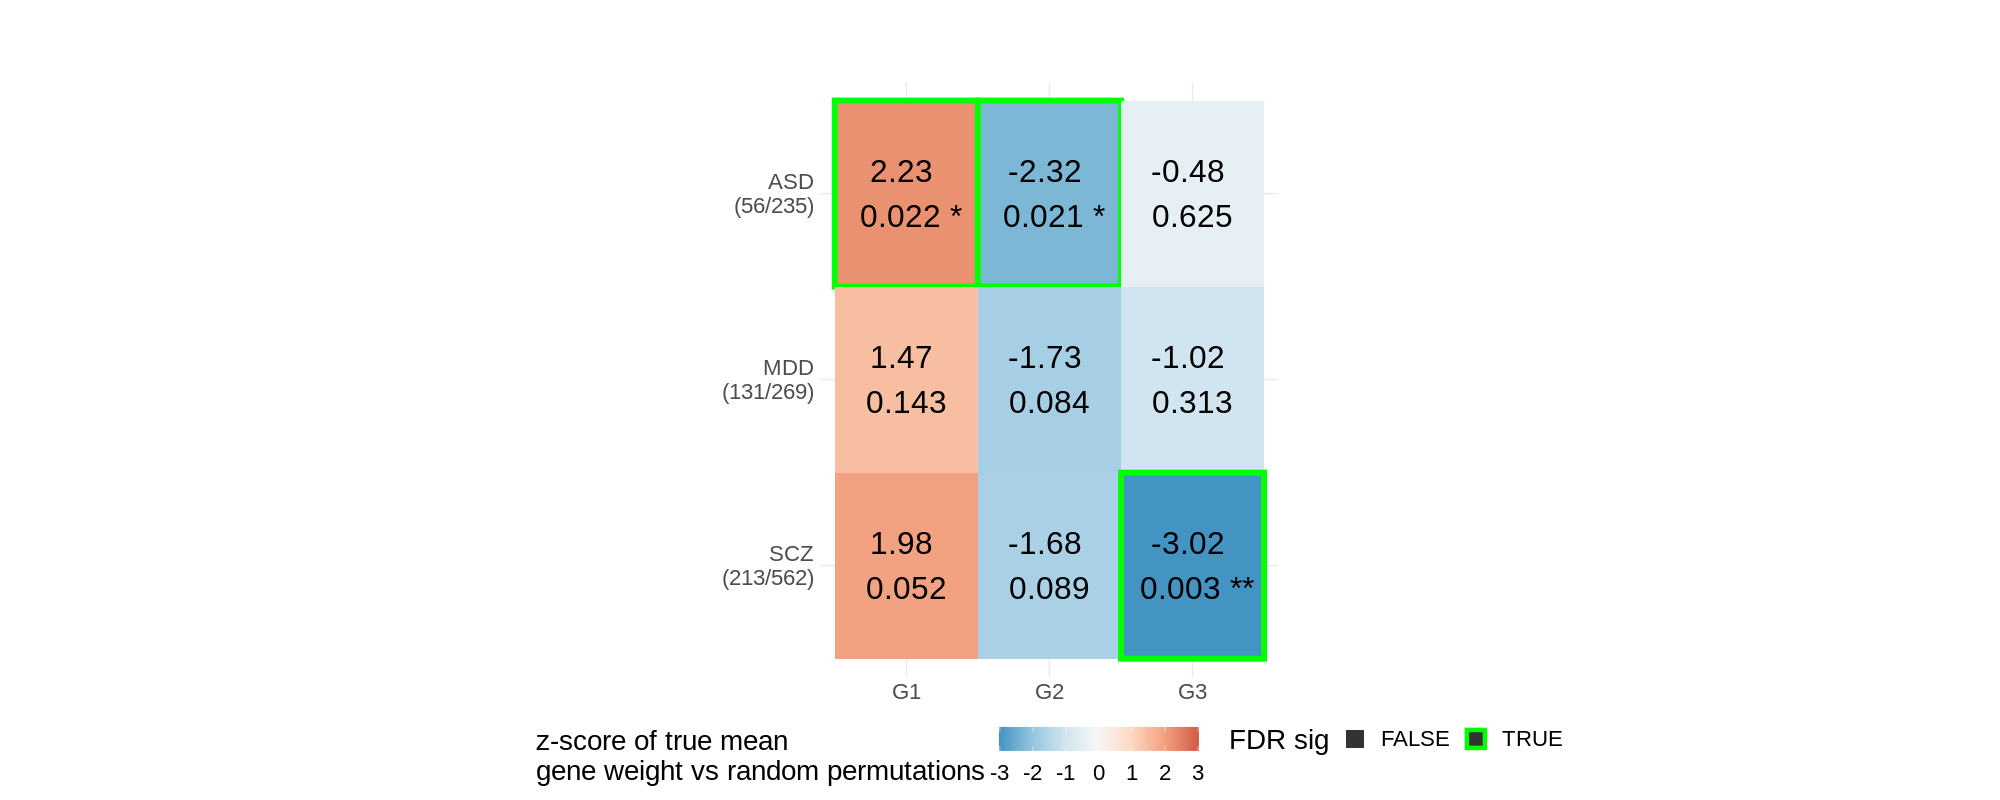

In [67]:
%%R -i gwas_stats -w 20 -h 8 --units in -r 100
source("../code/enrichmentsPlots.R")
gwas_stats %>% rename(version = data) %>% arrange(version) %>% 
mutate(how='') %>% 
plot_enrichment_heatmaps(scales='free') + theme(legend.position='bottom') +
guides(fill=guide_colourbar(title='z-score of true mean\ngene weight vs random permutations', barwidth=10))

Fit GAM models to all GWAS genes matched in BrainSpan

In [85]:
curves = get_brainspan_curves_by_gene(gwas_genes['gene'])

In [100]:
quantiles = make_label_quantiles_by_axis(weights, gwas_genes, q=5)

In [101]:
quantiles.sort_values('G_score')

,label,gene,G,G_score,G_quantile
866,SCZ,KIAA1549,G3,-0.030566,0
193,MDD,TENM2,G2,-0.030151,0
524,MDD,BSN,G3,-0.027849,0
794,SCZ,FRMPD4,G3,-0.027006,0
511,MDD,ANKS1B,G2,-0.026083,0
...,...,...,...,...,...
242,MDD,HLA-B,G3,0.023916,4
200,MDD,BTN3A2,G3,0.024480,4
679,SCZ,CNTN4,G2,0.024615,4
613,SCZ,BCL11B,G2,0.027090,4


In [102]:
quantile_curves = (quantiles
 .join(curves.set_index('gene'), on='gene').dropna()
 .groupby(['label','G','G_quantile','age_log10'])
 .agg({'pred':'mean', 'pred_q75':'mean'})
 .reset_index()
)
quantile_curves

,label,G,G_quantile,age_log10,pred,pred_q75
0,ASD,G1,0,1.748188,1.007806,0.615977
1,ASD,G1,0,1.772677,1.023307,0.625701
2,ASD,G1,0,1.797166,1.038807,0.635423
3,ASD,G1,0,1.821655,1.054311,0.645144
4,ASD,G1,0,1.846144,1.069824,0.654867
...,...,...,...,...,...,...
4495,SCZ,G3,4,4.074647,0.850479,0.904964
4496,SCZ,G3,4,4.099136,0.848863,0.908985
4497,SCZ,G3,4,4.123625,0.847225,0.912942
4498,SCZ,G3,4,4.148114,0.845575,0.916851


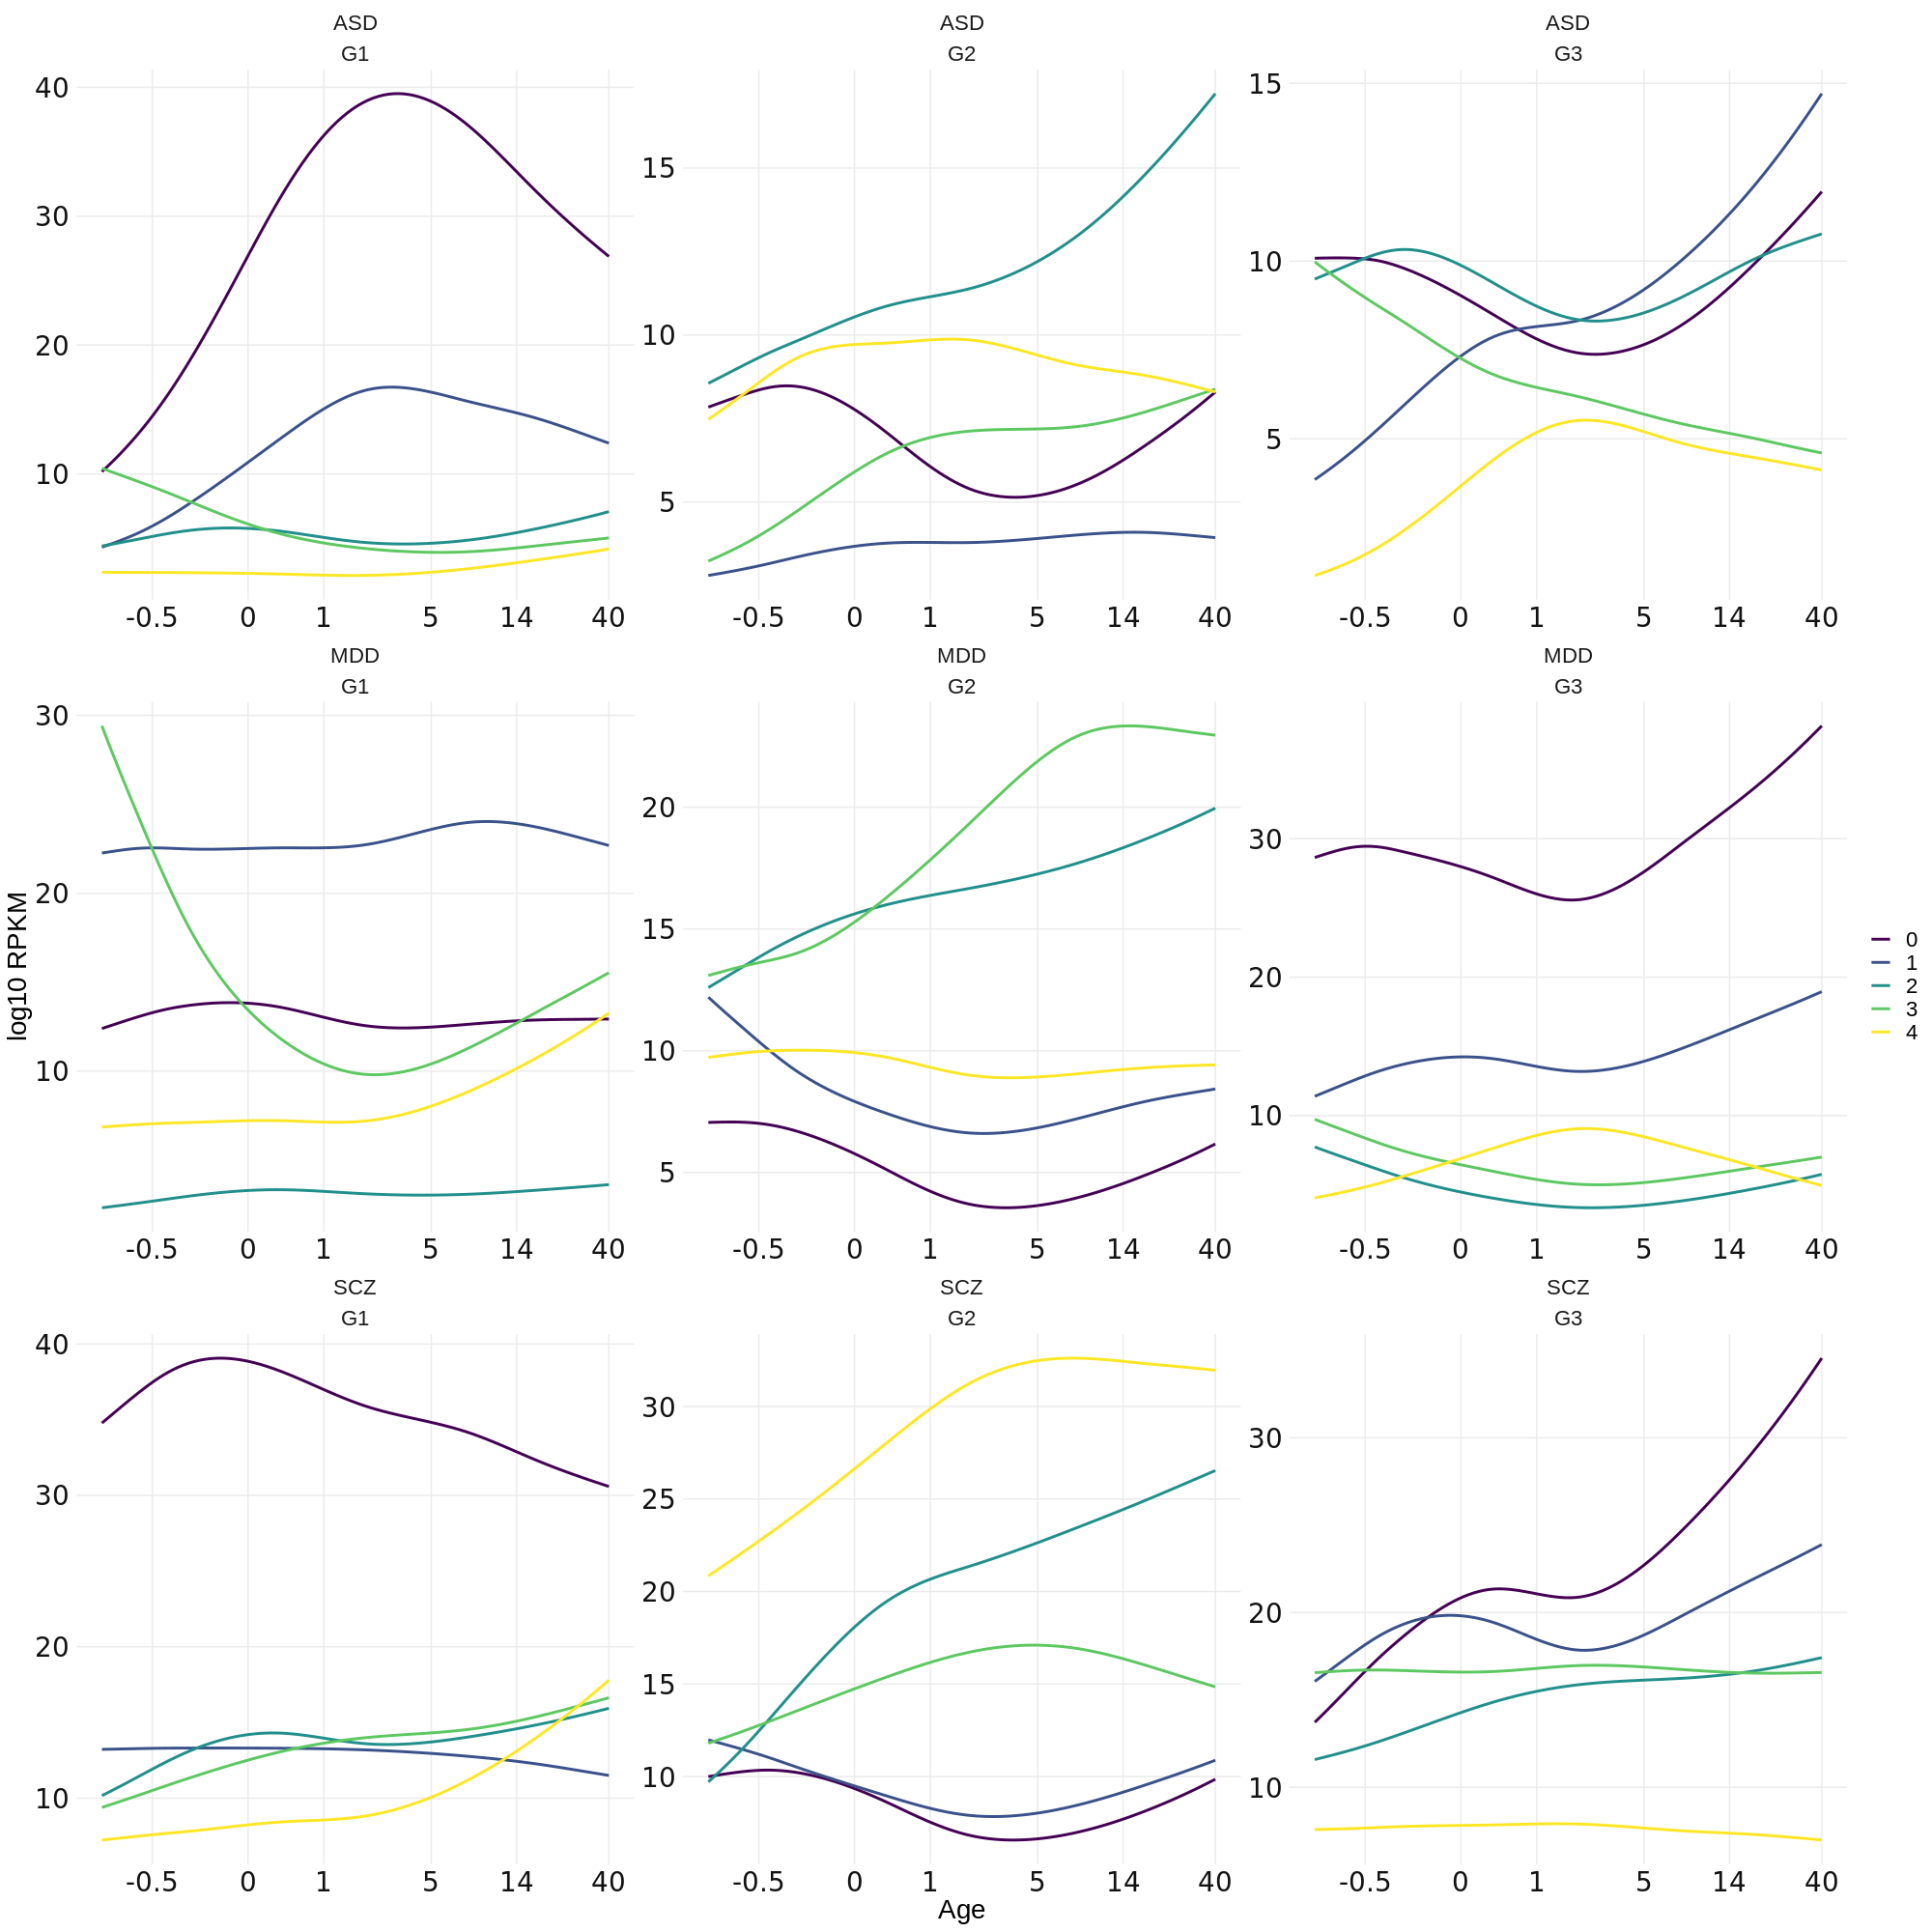

In [104]:
%%R -i quantile_curves -w 20 -h 20 -u in -r 100
source("../code/brainspanPlots.R")
quantile_curves %>% 
# filter(G_quantile>5) %>% 
rename(disorder=label, label=G_quantile) %>% 
plot_quantile_curves(facet='~disorder+G')

In [40]:
from brainspan import *
hcp_bs_mapping = get_hcp_bs_mapping_v2()
bs_exp, bs_col, bs_row = get_brainspan()
bs_clean = clean_brainspan(bs_exp, bs_col, bs_row, hcp_bs_mapping)
bs_continuous = make_continuous(bs_clean, norm_samples=True)

In [41]:
genes_to_fit = np.intersect1d(bs_clean.columns, gwas_genes['gene'].dropna())
gwas_genes_models = fit_gam_models(bs_continuous, genes_to_fit, alpha=.5)
gwas_genes_curves, gwas_genes_points = predict_gam_curves(gwas_genes_models, bs_continuous, genes_to_fit)

In [49]:
quantiles_gwas = make_quantiles_plot(weights, q=5, labels=gwas_genes, levels=None, na_value='No GWAS').dropna()

In [50]:
quantiles_age_curves_plot = (quantiles_gwas
#  .query("G=='G3'")
 .join(gwas_genes_curves.set_index('gene'), on='gene')
 .groupby(['label','G','G_quantile','age_log10'])
 .agg({'pred':'mean', 'gene':'count'}).rename({'gene':'n_genes'}, axis=1)
 .reset_index()
)

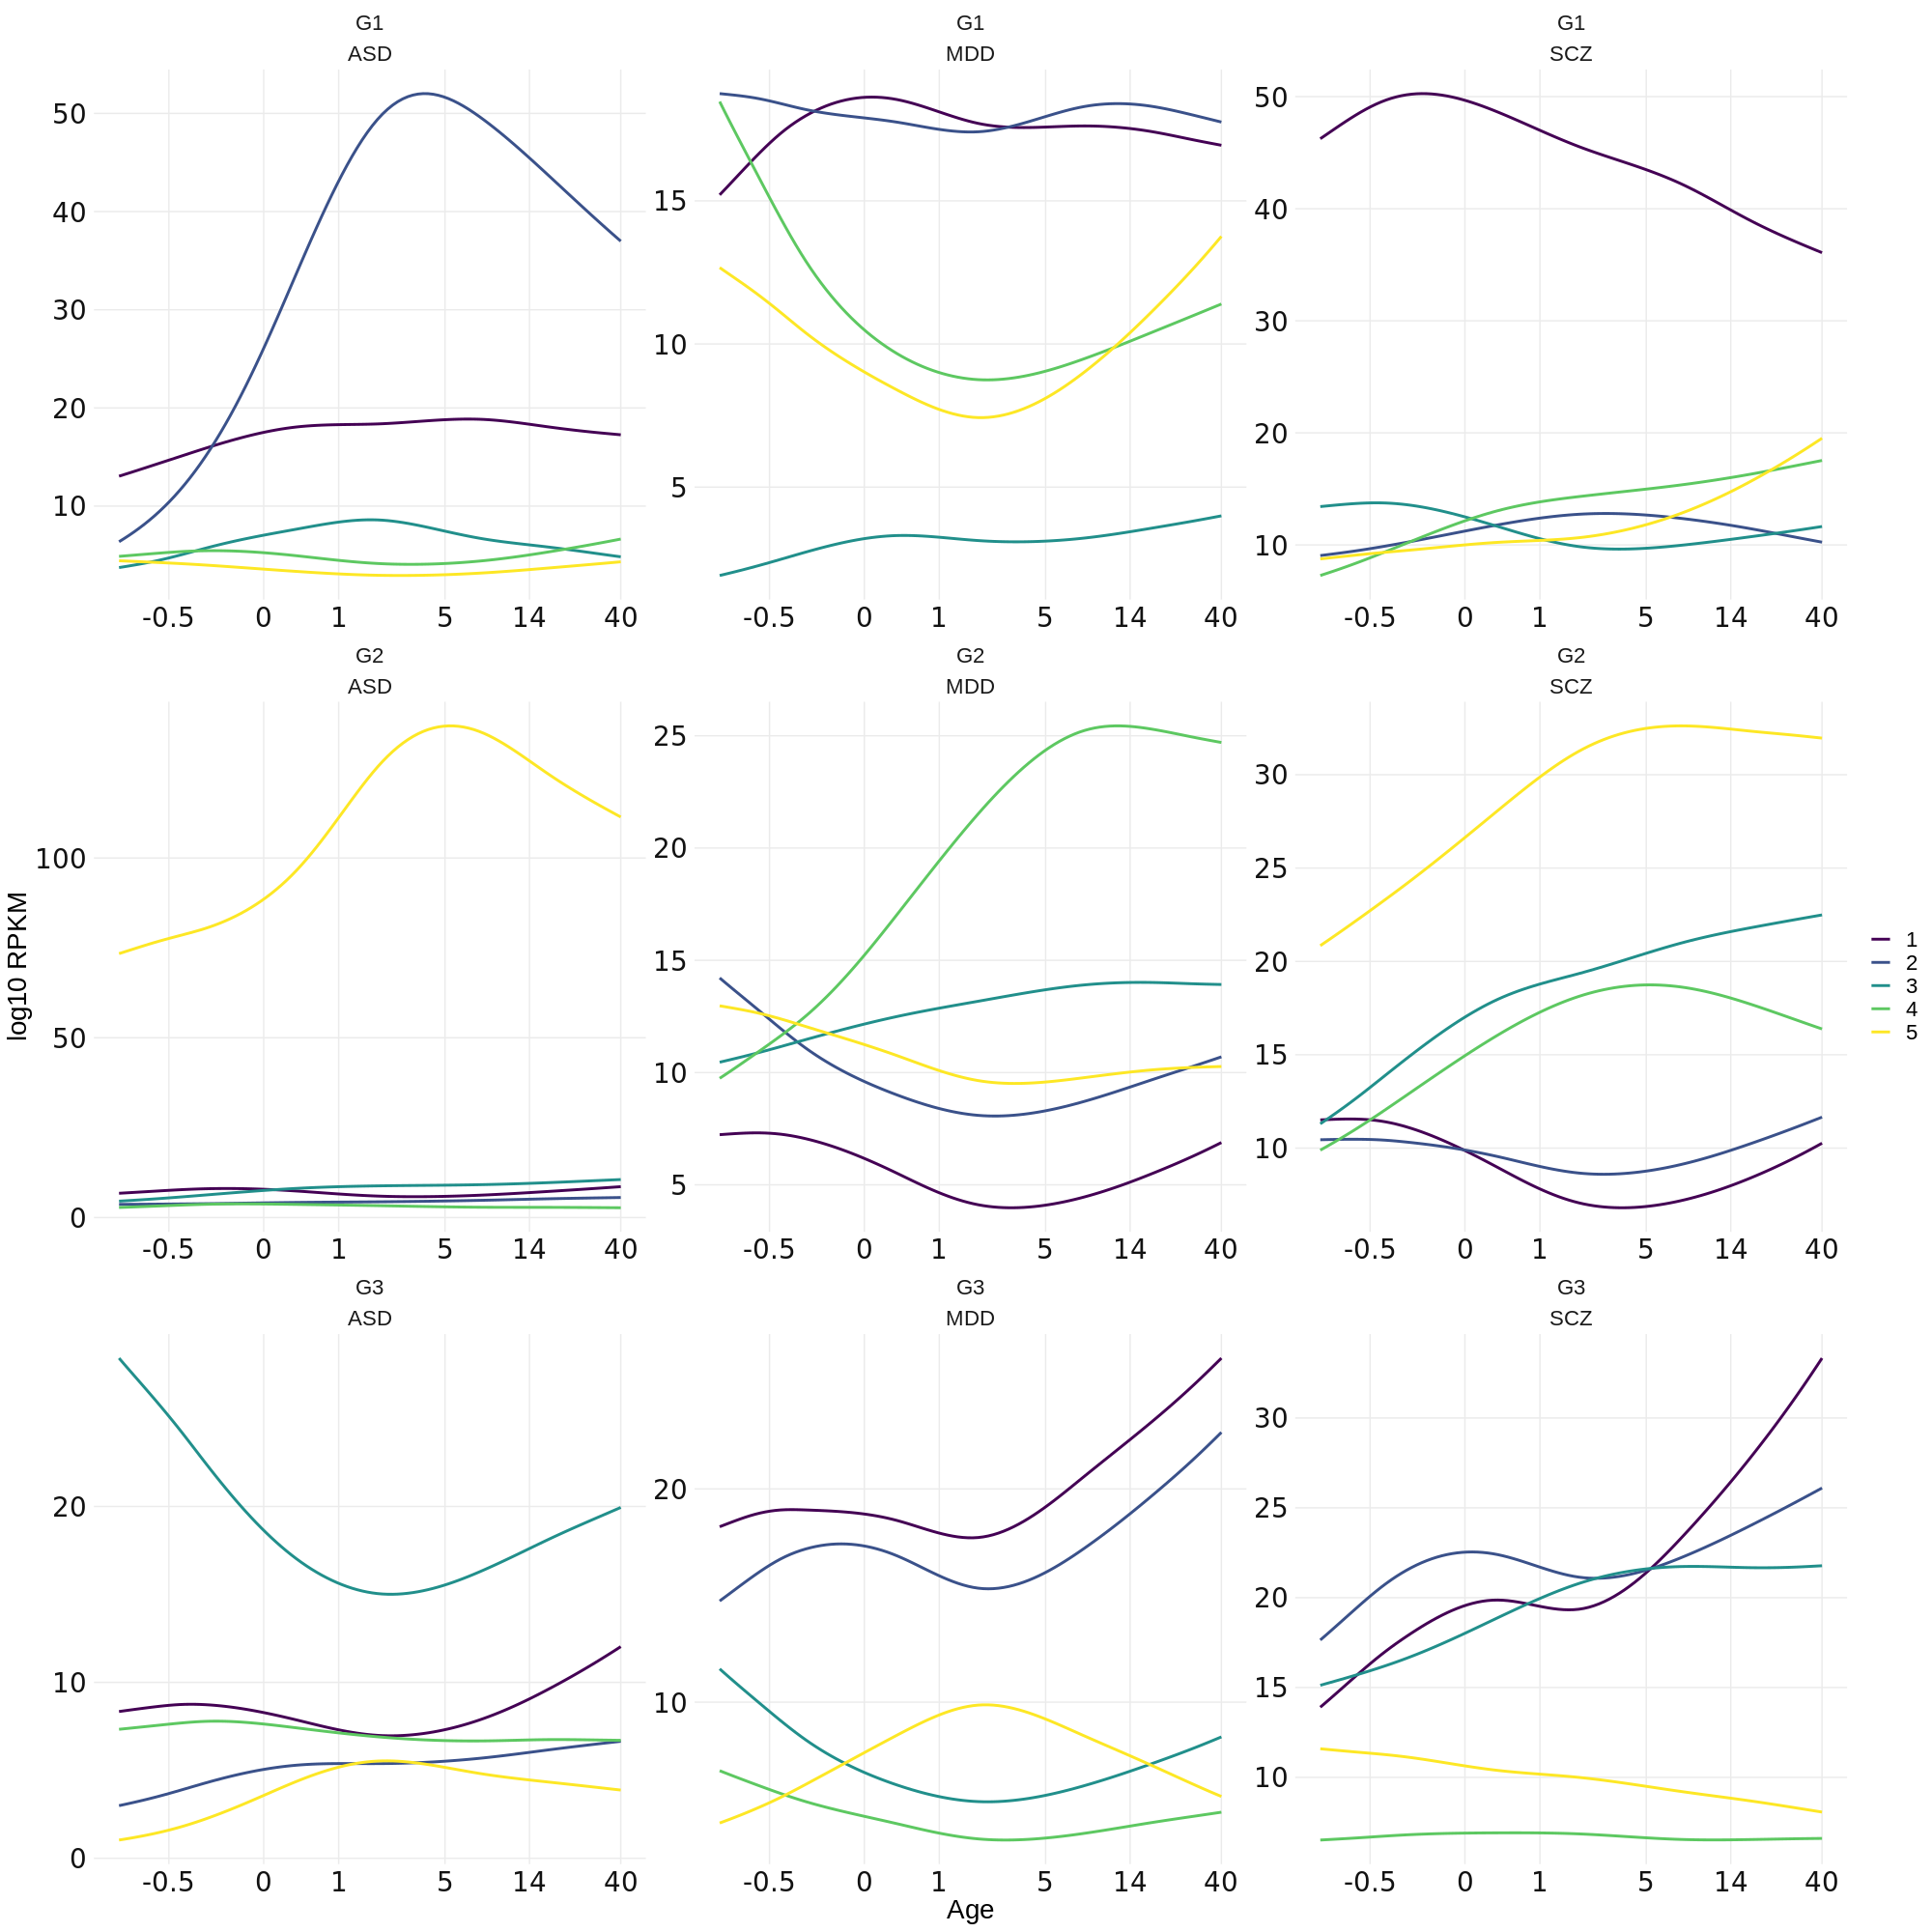

In [54]:
%%R -i quantiles_age_curves_plot -w 20 -h 20 -u in -r 100
source("../code/brainspanPlots.R")
quantiles_age_curves_plot %>% 
# filter(n_genes > 5) %>% 
plot_quantiles_age_curves(facet='')

## Structure

In [55]:
structure = (pd.read_csv("../data/gwas/warrier2022_tableS23.csv", index_col=0, header=1).reset_index()
             .rename({'Phenotype':'label', 'Gene Symbol':'gene'}, axis=1)
            #  .loc[lambda x: x['N occurences']>1]
)

# structure = (pd.read_csv("../data/gwas/warrier2022_tableS24.csv", index_col=0, header=2).reset_index()
#              .rename({'Gene name':'gene'}, axis=1)
#              .assign(label = 'all structure')
# )

# thickness = pd.read_csv("../data/gwas/grasby2020.csv", index_col=0).reset_index()
# thickness = pd.read_csv("../data/gwas/makowski2022_magma.csv", index_col=0).reset_index()
structure.head()

,label,gene,hiC germinal zone,hiC cortical plate,hiC neuron,hiC glia,SMR methylation,SMR postnatal_eqtl,SMR prenatal_eQTL,Closest gene,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,Volume,AC005153.1,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Surface area,AC005829.2,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Local gyrification index,AC005829.2,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Isotropic volume fraction,AC005829.2,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Mean diffusivity,AC005829.2,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
structure_stats = compute_null_p(*compute_enrichments(weights, nulls, structure, posneg=''))

In [57]:
structure_stats = (structure_stats
    .assign(label = lambda x: [f"{label}\n({n_matches}/{n_genes})" for label, n_matches, n_genes in
                                        zip(x['label'], x['n_matches'], x['n_genes'])]))

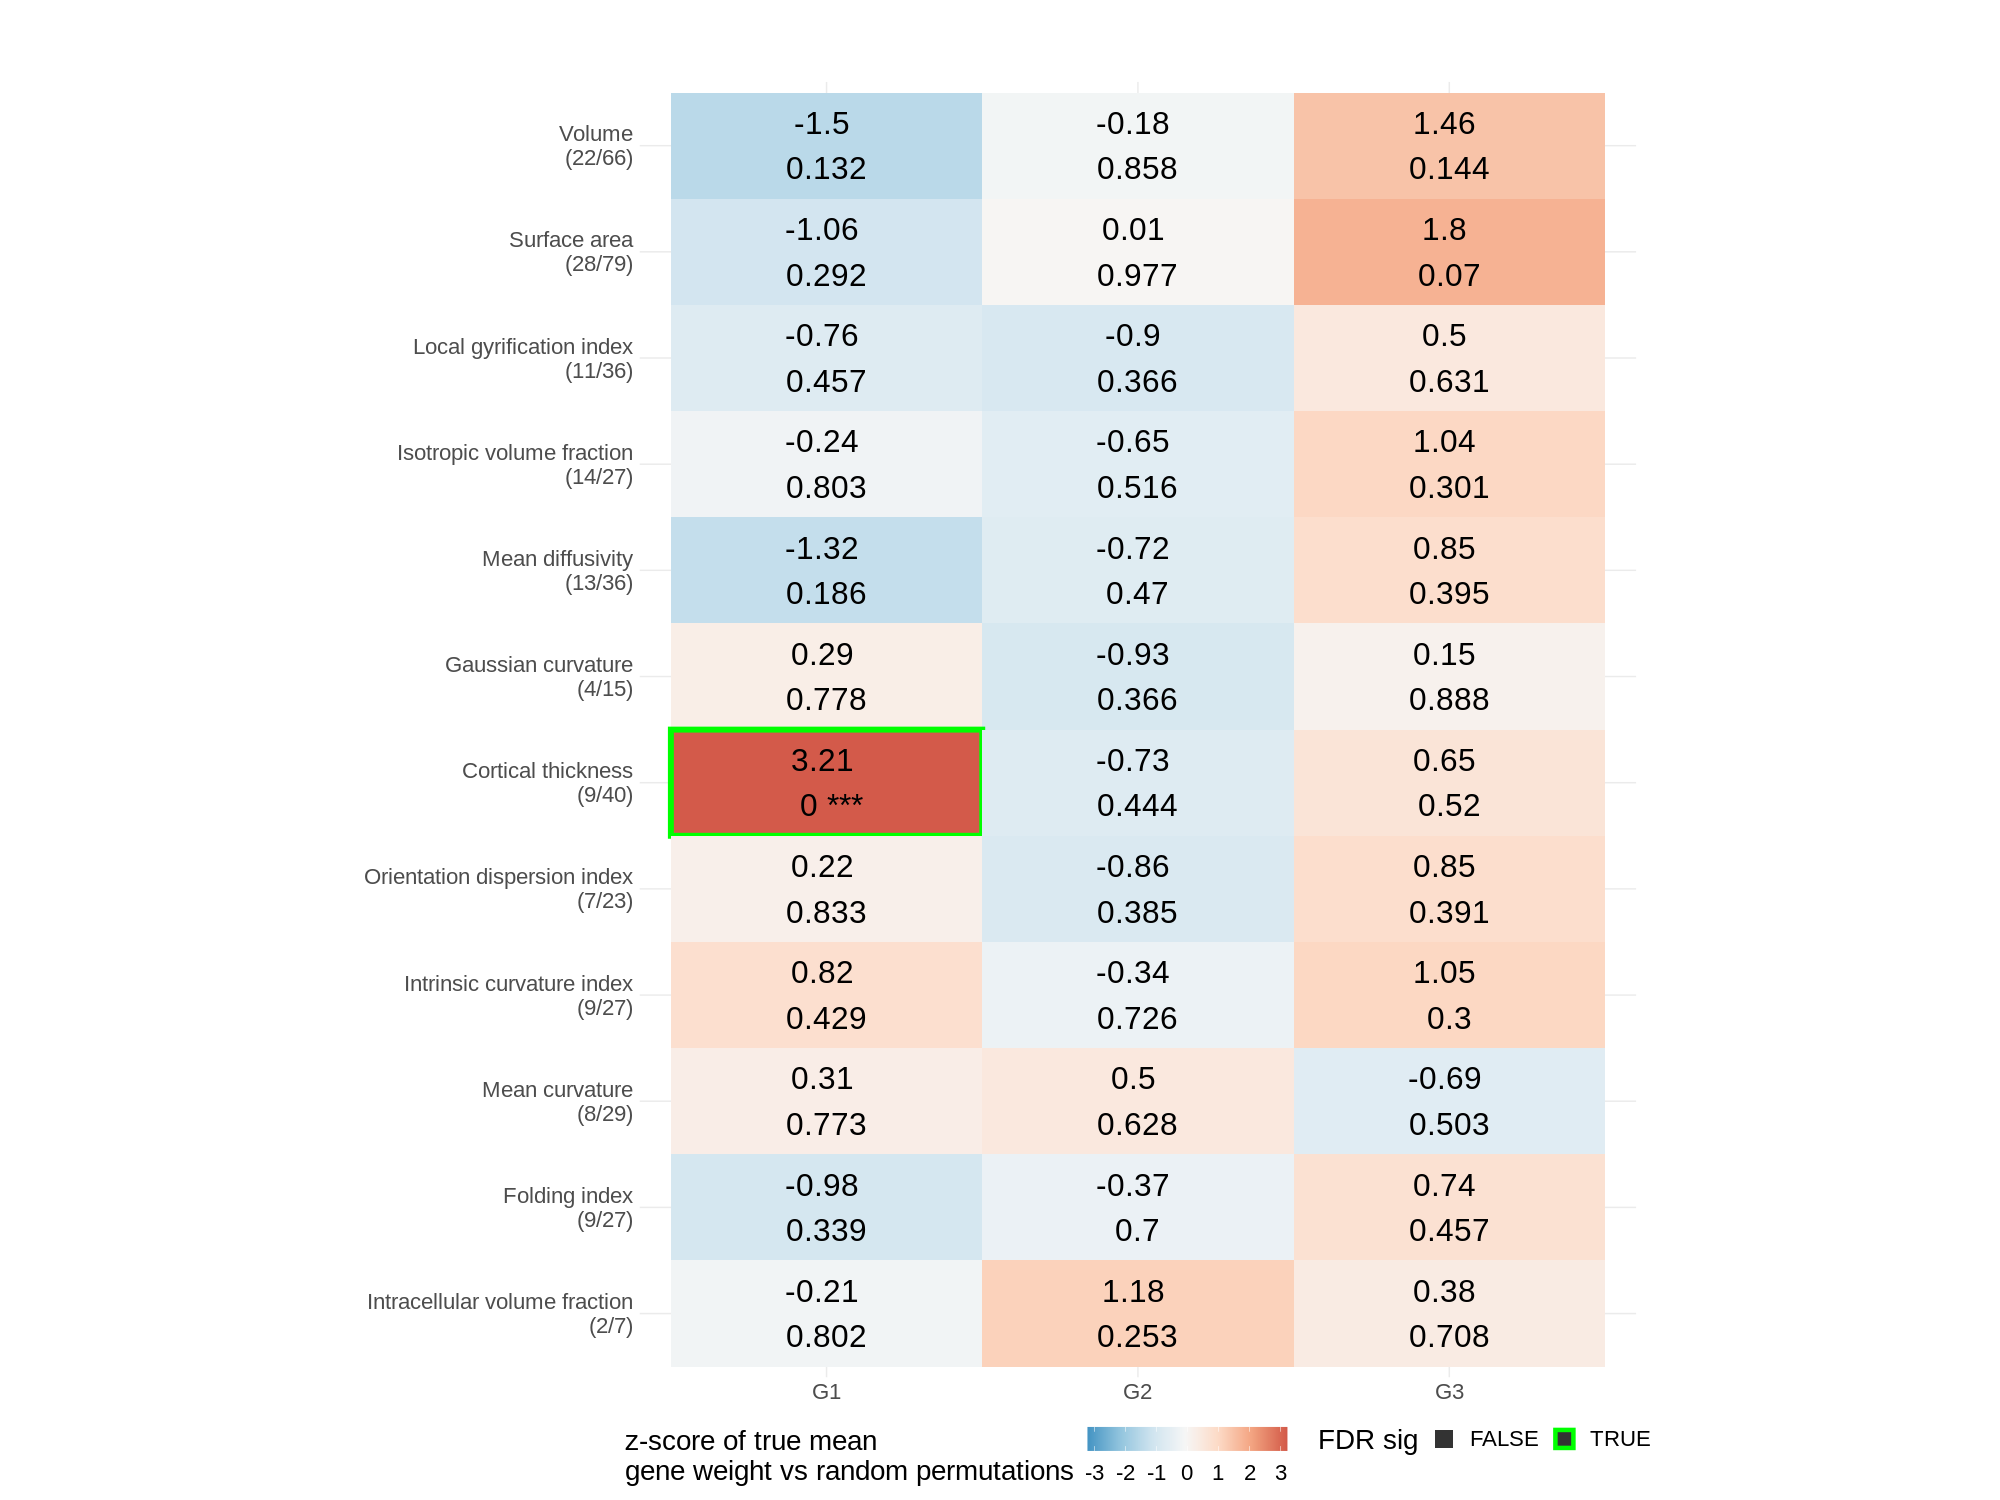

In [60]:
%%R -i structure_stats -w 20 -h 15 --units in -r 100
source("../code/enrichmentsPlots.R")
structure_stats %>% mutate(how='', version='') %>% 
plot_enrichment_heatmaps() + theme(legend.position='bottom') +
guides(fill=guide_colourbar(title='z-score of true mean\ngene weight vs random permutations', barwidth=10))

## All genes from Eva's H-MAGMA

In [564]:
import biomapy as bp

(pd.read_fwf("../data/gwas/FB_SCZ.genes.csv")
 .assign(SYMBOL = lambda x: bp.gene_mapping_many(x['GENE'], 'ensembl', 'symbol'))
).to_csv("../data/eva_SCZ_genes.csv")




In [147]:
from statsmodels.stats.multitest import multipletests

scz_genes = (pd.read_csv("../data/eva_SCZ_genes.csv", index_col=0)
        .dropna().loc[:,['CHR','ZSTAT','P','SYMBOL']].set_axis(['chromosome','zstat','p','gene'],axis=1)
        .assign(q = lambda x: multipletests(x['p'], method='bonferroni')[1])
        .loc[lambda x: x['q']<0.05]
        .set_index('gene')
        .join(dme_3d_ds5.weights.iloc[:,:3].set_axis(['G1','G2','G3'],axis=1))
        .dropna()
        .melt(ignore_index=False, id_vars=['chromosome','zstat','p','q'], var_name='G', value_name='weight')
        .assign(chromosome = lambda x: np.where(np.isin(x['chromosome'], [3,17]), x['chromosome'], 'other'))
        .assign(log_p = lambda x: np.log10(x['p']))#.drop('p',axis=1)
        # .melt(id_vars=['chromosome','G','weight'], var_name='metric', value_name='value', ignore_index=False)
)
scz_genes

,chromosome,zstat,p,q,G,weight,log_p
gene,,,,,,,
PEX10,other,5.6997,6.001000e-09,0.000191,G1,-0.014054,-8.221776
YTHDF2,other,4.6690,1.513300e-06,0.048106,G1,-0.011783,-5.820075
SMIM12,other,5.3566,4.240800e-08,0.001348,G1,0.005117,-7.372552
AGO1,other,5.4257,2.885800e-08,0.000917,G1,0.017817,-7.539734
AGO3,other,5.6193,9.587200e-09,0.000305,G1,0.008928,-8.018308
...,...,...,...,...,...,...,...
L3MBTL2,other,4.8526,6.092000e-07,0.019366,G3,-0.018772,-6.215240
CHADL,other,5.2723,6.735300e-08,0.002141,G3,0.021070,-7.171643
MEI1,other,5.9796,1.118800e-09,0.000036,G3,-0.012720,-8.951248


In [154]:
scz_genes_label = pd.DataFrame({'gene':scz_genes.index, 'label':scz_genes.chromosome})
compute_null_p(*compute_enrichments(weights, nulls, scz_genes_label, posneg=''))

,label,G,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
0,other,G1,0.8988,0.000282,-0.000610,0.000697,1.279581,True,0.2024,0.7164,False,753,251
1,other,G2,0.7188,0.001329,0.000928,0.000697,0.575962,True,0.5624,0.7335,False,753,251
2,other,G3,0.5862,-0.000113,-0.000267,0.000701,0.219291,True,0.8276,0.8276,False,753,251
3,3,G1,0.3168,-0.001818,-0.000631,0.002496,-0.475423,False,0.6336,0.7335,False,60,20
4,3,G2,0.1194,-0.002020,0.000927,0.002465,-1.195641,False,0.2388,0.7164,False,60,20
5,3,G3,0.2296,-0.002039,-0.000244,0.002457,-0.730290,False,0.4592,0.7335,False,60,20
6,17,G1,0.7742,0.002310,-0.000697,0.003956,0.760186,True,0.4516,0.7335,False,24,8
7,17,G2,0.6740,0.002773,0.000960,0.003959,0.457942,True,0.6520,0.7335,False,24,8
8,17,G3,0.8850,0.004541,-0.000249,0.003986,1.201863,True,0.2300,0.7164,False,24,8


`geom_smooth()` using formula = 'y ~ x'


/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


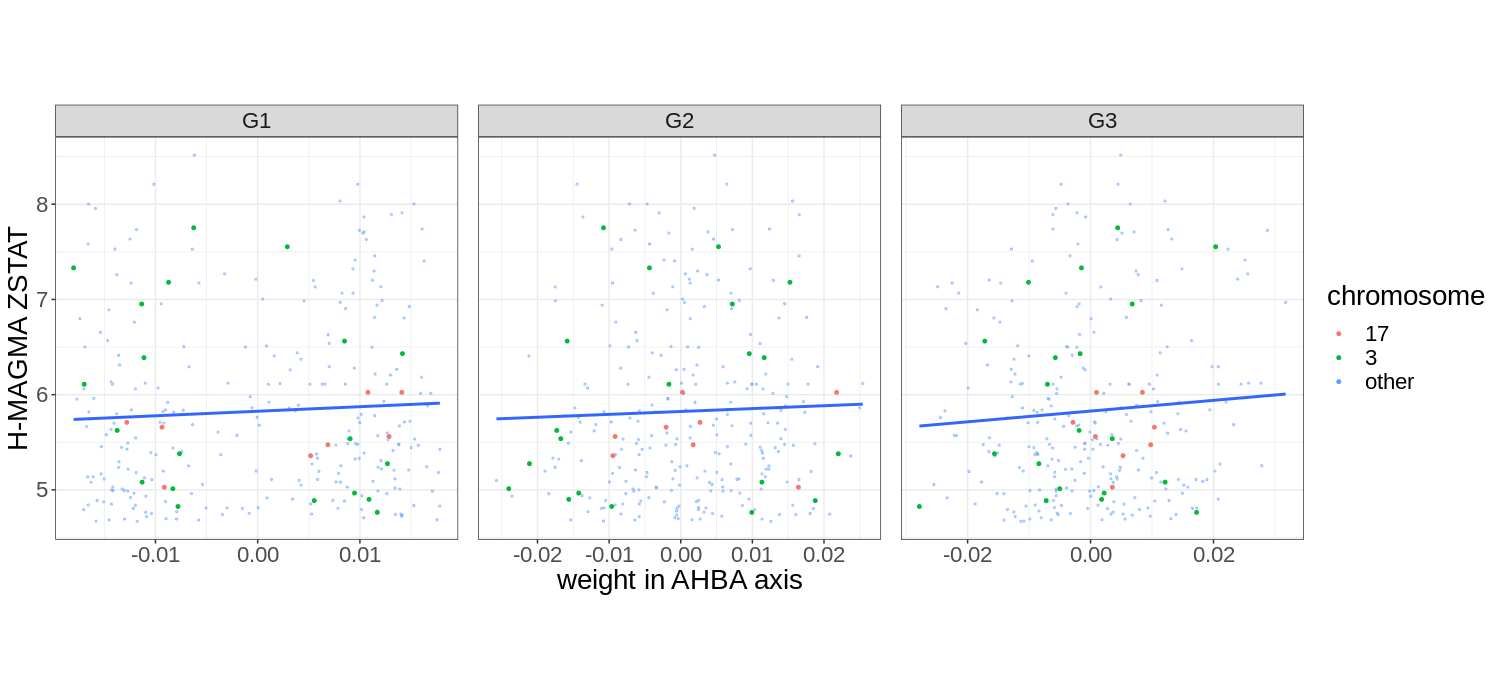

In [148]:
%%R -i scz_genes -w 15 -h 7 --units in -r 100
scz_genes %>%
ggplot(aes(weight, zstat)) + 
facet_grid(. ~ G, scales='free') +
geom_point(aes(color=chromosome), size=.5, alpha=.4) +
geom_point(aes(color=chromosome), size=1, alpha=1, data=scz_genes %>% filter(chromosome %in% c('17','3'))) +
geom_smooth(method='lm', se=F) +
xlab('weight in AHBA axis') +
ylab('H-MAGMA ZSTAT') +
theme_bw() +
theme(panel.spacing=unit(1,'lines'),
      aspect.ratio=1,
      text=element_text(size=20)
)


## ASD Grove & Matoba

In [114]:
gwas_genes = get_gwas('matoba2020_grove2019').loc[lambda x: x['label']!='grove2019']
gwas_genes

,label,gene
0,matoba2022,RBM6
1,matoba2022,KMT2E
2,matoba2022,PAFAH1B1
3,matoba2022,TFAP2D
4,matoba2022,CELSR3
...,...,...
525,matoba2022,RN7SL739P
531,matoba2022,LRRC37A16P
553,matoba2022,RPP40P2
561,matoba2022,MUSTN1


In [115]:
gwas_stats_dict = {
    # 'absolute': compute_null_p(*compute_enrichments(weights, nulls, gwas_genes, posneg='abs')),
    'not absolute': compute_null_p(*compute_enrichments(weights, nulls, gwas_genes, posneg=''))
}

In [116]:
gwas_stats = (pd.concat(gwas_stats_dict).reset_index(0).rename({'level_0':'data'}, axis=1)
    .assign(label = lambda x: [f"{label}\n({n_matches}/{n_genes})" for label, n_matches, n_genes in
                                        zip(x['label'], x['n_matches'], x['n_genes'])]))

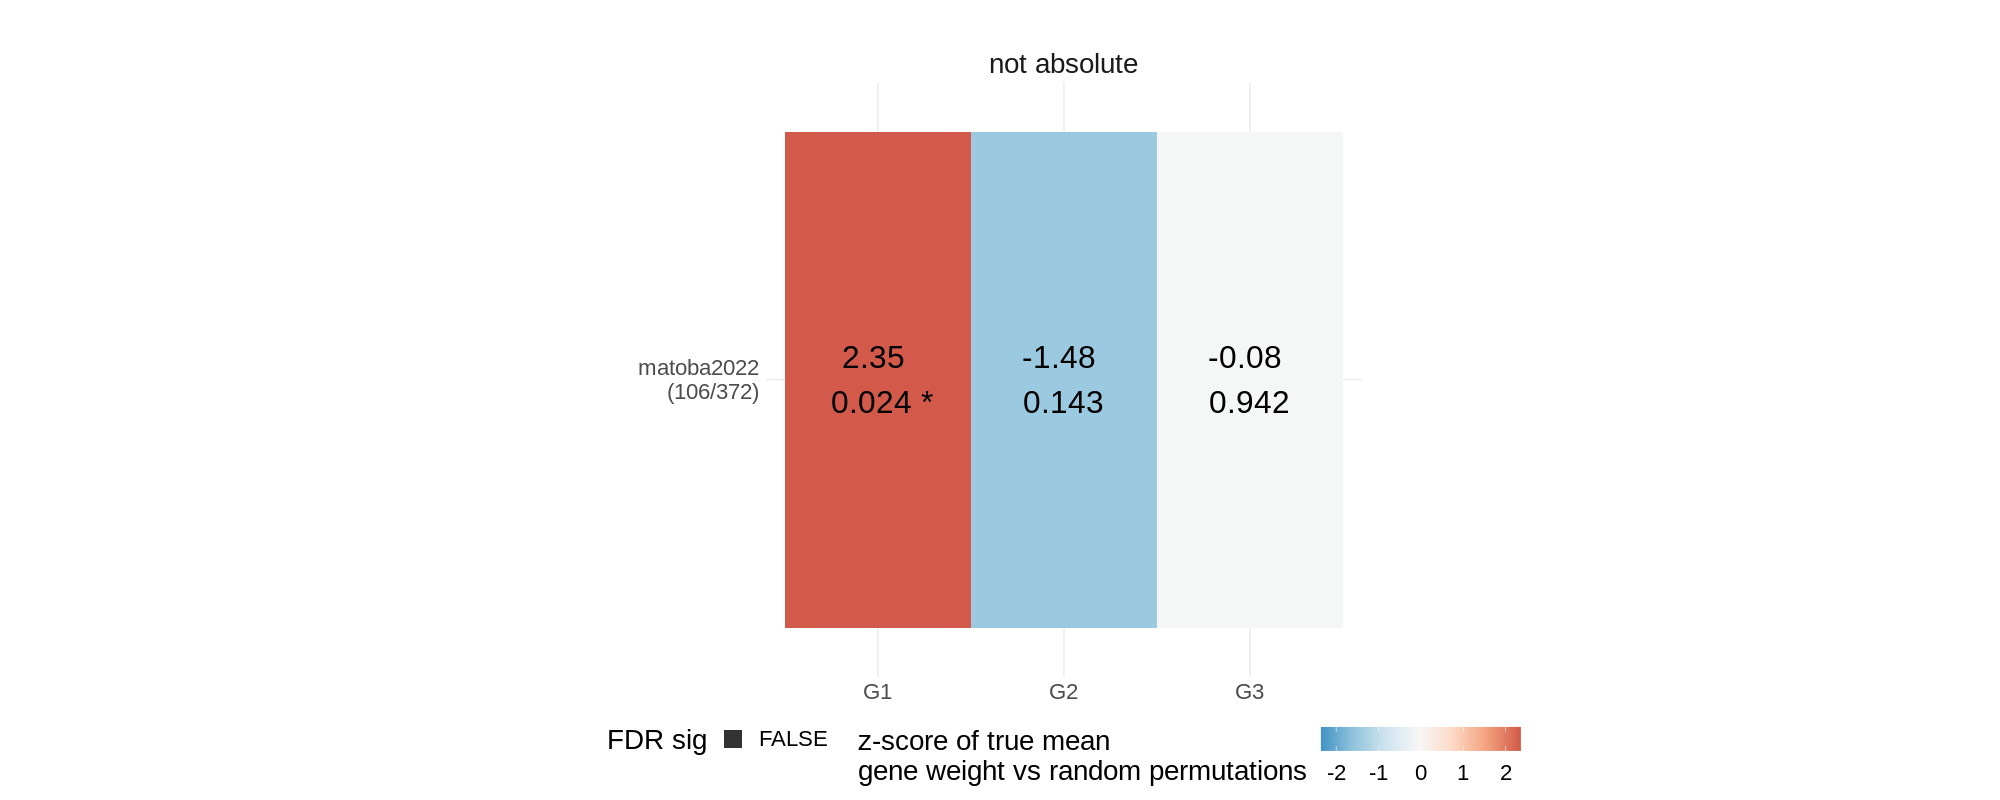

In [117]:
%%R -i gwas_stats -w 20 -h 8 --units in -r 100
source("../code/enrichmentsPlots.R")
gwas_stats %>% rename(version = data) %>% arrange(version) %>% 
mutate(how='') %>% 
plot_enrichment_heatmaps(scales='free') + theme(legend.position='bottom') +
guides(fill=guide_colourbar(title='z-score of true mean\ngene weight vs random permutations', barwidth=10))

## Trubetskoy2022 genes

In [9]:
# gwas_genes = get_gwas('trubetskoy2022')
# get_gwas('reay2020')
# get_gwas('grove2019_wray2018_pardinas2018')
# get_gwas('matoba2020_als2022_ripke2020')

replace_dict = {'01-Mar':'MARCH1', '02-Mar':'MARCH2', '03-Mar':'MARCH3', '04-Mar':'MARCH4', '05-Mar':'MARCH5', '06-Mar':'MARCH6', '07-Mar':'MARCH7', '08-Mar':'MARCH8', 
                '09-Mar':'MARCH9', '10-Mar':'MARCH10', '11-Mar':'MARCH11',
                '01-Sep':'SEPT1', '02-Sep':'SEPT2', '03-Sep':'SEPT3', '04-Sep':'SEPT4', '05-Sep':'SEPT5', '06-Sep':'SEPT6', '07-Sep':'SEPT7', '08-Sep':'SEPT8',
                '09-Sep':'SEPT9', '10-Sep':'SEPT10', '11-Sep':'SEPT11', '12-Sep':'SEPT12', '13-Sep':'SEPT13', '14-Sep':'SEPT14', '15-Sep':'SEPT15', 
                '01-Dec':'DECR1', '02-Dec':'DECR2'}

In [31]:
trubetskoy_genes = pd.read_csv("../data/gwas/trubetskoy2022_extended.csv")
gwas_genes = (pd.concat({
    'Extended.GWAS': trubetskoy_genes.loc[lambda x: x["Extended.GWAS"]=='YES', 'Symbol.ID'],
    'FINEMAPk3.5': trubetskoy_genes.loc[lambda x: x["FINEMAPk3.5"]==1, 'Symbol.ID'],
    'k3.5singleGene': trubetskoy_genes.loc[lambda x: x["k3.5singleGene"]==1, 'Symbol.ID'],
    'SMRpsych': trubetskoy_genes.loc[lambda x: x["SMRpsych"]==1, 'Symbol.ID']
}).reset_index(0)
  .set_axis(['label','gene'], axis=1)
  .replace({'gene': replace_dict})
)
gwas_genes

,label,gene
0,Extended.GWAS,ABCB9
1,Extended.GWAS,ABHD2
2,Extended.GWAS,AC003088.1
3,Extended.GWAS,AC004159.1
4,Extended.GWAS,AC005609.2
...,...,...
626,SMRpsych,THOC7
628,SMRpsych,TMEM110
655,SMRpsych,WDR76
656,SMRpsych,WDR82


In [32]:
gwas_stats_dict = {
    # 'absolute': compute_null_p(*compute_enrichments(weights, nulls, gwas_genes, posneg='abs')),
    'not absolute': compute_null_p(*compute_enrichments(weights, nulls, gwas_genes, posneg=''))
}

In [33]:
gwas_stats = (pd.concat(gwas_stats_dict).reset_index(0).rename({'level_0':'data'}, axis=1)
    .assign(label = lambda x: [f"{label}\n({n_matches}/{n_genes})" for label, n_matches, n_genes in
                                        zip(x['label'], x['n_matches'], x['n_genes'])]))

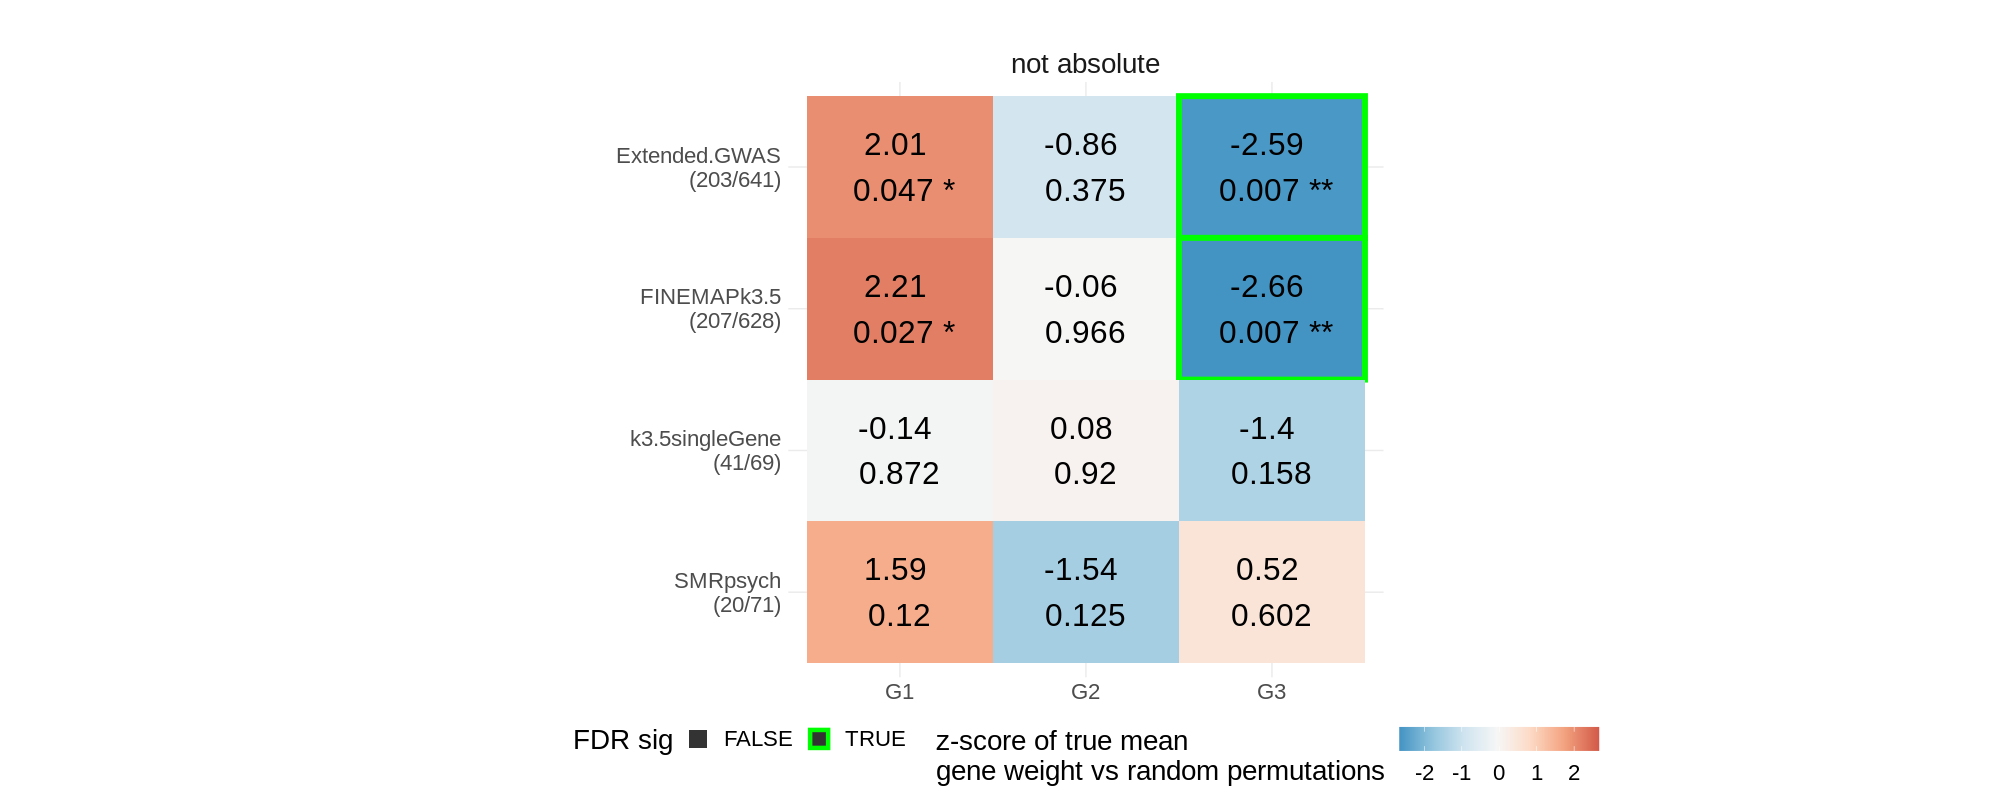

In [34]:
%%R -i gwas_stats -w 20 -h 8 --units in -r 100
source("../code/enrichmentsPlots.R")
gwas_stats %>% rename(version = data) %>% arrange(version) %>% 
mutate(how='') %>% 
plot_enrichment_heatmaps(scales='free') + theme(legend.position='bottom') +
guides(fill=guide_colourbar(title='z-score of true mean\ngene weight vs random permutations', barwidth=10))

In [407]:
gwas_genes_dict = {
    'grove2019_wray2018_pardinas2018': get_gwas('grove2019_wray2018_pardinas2018'),
    # 'pardinas2018_other': get_gwas('pardinas2018_other'),
    'matoba2020_als2022_ripke2020': get_gwas('matoba2020_als2022_ripke2020'),
    'li2018': get_gwas('li2018'),
    'li2018_hiC_strict': get_gwas('li2018_hiC_strict'),
    'reay2020': get_gwas('reay2020'),
    'hammerschlag2020_yang2021_trubetskoy2022': get_gwas('hammerschlag2020_yang2021_trubetskoy2022')
}

gwas_stats_dict = {
    name: compute_null_p(*compute_enrichments(weights, nulls, gwas_genes, posneg='abs'))
    for name, gwas_genes in gwas_genes_dict.items()
}

In [260]:
# gwas_genes.pop('pain2019_yang2021_trubetskoy2022')
# gwas_genes = get_gwas('hammerschlag2020_yang2021_trubetskoy2022')
# gwas_stats_dict['hammerschlag2020_yang2021_trubetskoy2022']=compute_null_p(*compute_enrichments(weights, nulls, gwas_genes, posneg='abs'))

In [408]:
gwas_stats = (pd.concat(gwas_stats_dict).reset_index(0).rename({'level_0':'data'}, axis=1)
              .assign(label = lambda x: [f"{label}\n({n_matches}/{n_genes})" for label, n_matches, n_genes in
                                        zip(x['label'], x['n_matches'], x['n_genes'])]))
gwas_stats.head(10)

,data,label,G,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
0,grove2019_wray2018_pardinas2018,ASD\n(9/15),G1,0.5776,0.010642,0.010301,0.001500,0.227628,True,0.8448,0.95040,False,15,9
1,grove2019_wray2018_pardinas2018,ASD\n(9/15),G2,0.8972,0.011930,0.009099,0.002184,1.295906,True,0.2056,0.58230,False,15,9
2,grove2019_wray2018_pardinas2018,ASD\n(9/15),G3,0.3850,0.008243,0.008971,0.002177,-0.334560,False,0.7700,0.95040,False,15,9
3,grove2019_wray2018_pardinas2018,MDD\n(62/153),G1,0.7378,0.010647,0.010283,0.000563,0.645934,True,0.5244,0.78660,False,153,62
4,grove2019_wray2018_pardinas2018,MDD\n(62/153),G2,0.1226,0.008141,0.009103,0.000831,-1.157680,False,0.2452,0.58230,False,153,62
5,grove2019_wray2018_pardinas2018,MDD\n(62/153),G3,0.8166,0.009787,0.009002,0.000848,0.924790,True,0.3668,0.66024,False,153,62
6,grove2019_wray2018_pardinas2018,SCZ\n(11/22),G1,0.4952,0.010320,0.010293,0.001338,0.020250,False,0.9904,0.99040,False,22,11
7,grove2019_wray2018_pardinas2018,SCZ\n(11/22),G2,0.8706,0.011406,0.009123,0.001996,1.144110,True,0.2588,0.58230,False,22,11
8,grove2019_wray2018_pardinas2018,SCZ\n(11/22),G3,0.0038,0.004169,0.009024,0.001998,-2.429129,False,0.0076,0.06840,False,22,11
0,matoba2020_als2022_ripke2020,ASD\n(106/372),G1,0.7744,0.010611,0.010294,0.000425,0.746127,True,0.4512,0.67680,False,372,106


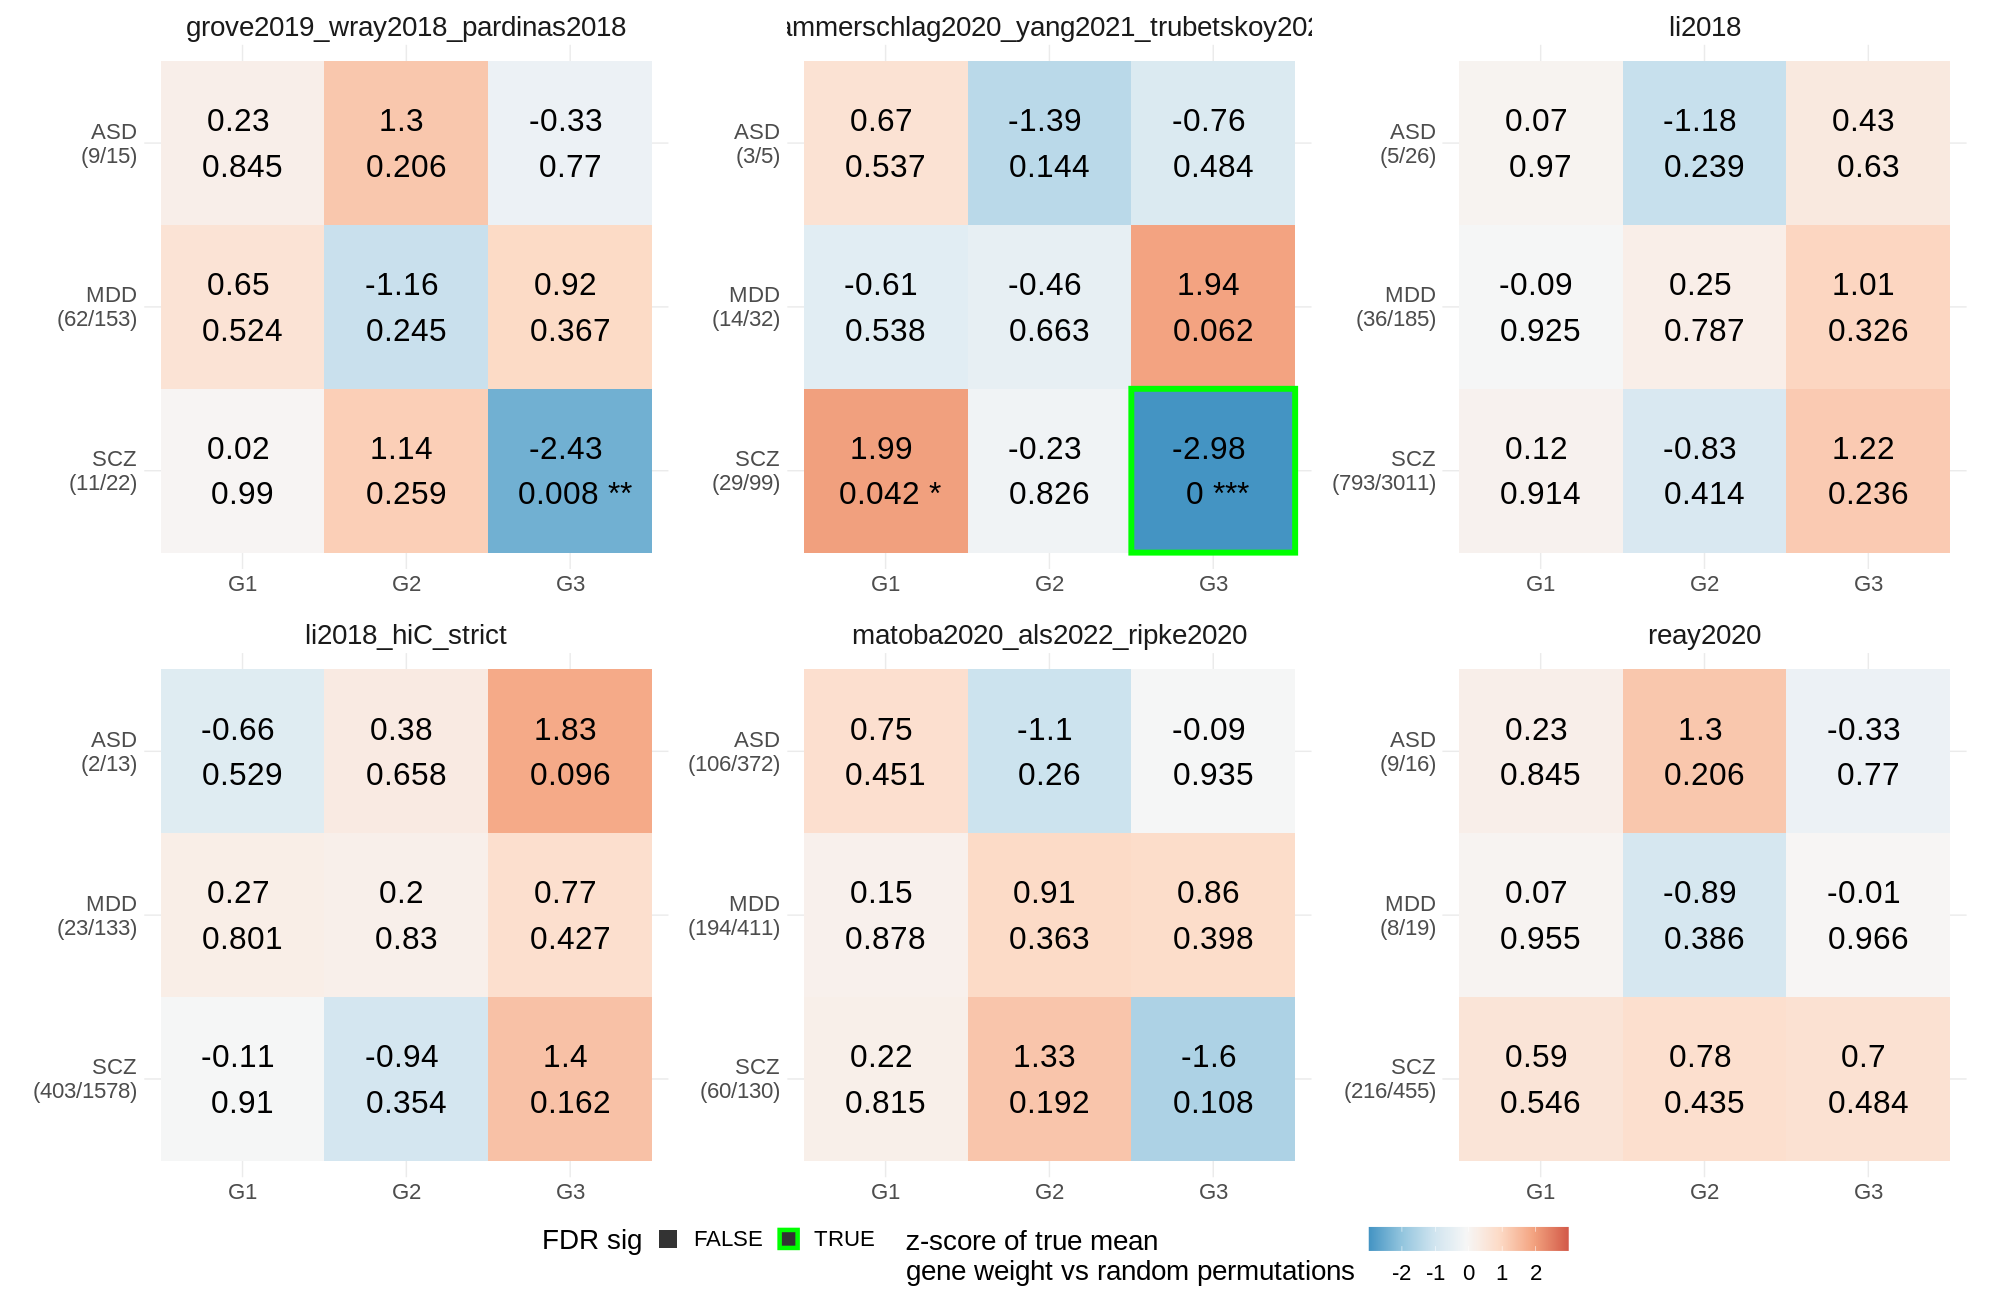

In [409]:
%%R -i gwas_stats -w 20 -h 13 --units in -r 100
source("../code/enrichmentsPlots.R")
gwas_stats %>% rename(version = data) %>% arrange(version) %>% 
plot_enrichment_heatmaps(scales='free') + theme(legend.position='bottom') +
guides(fill=guide_colourbar(title='z-score of true mean\ngene weight vs random permutations', barwidth=10))

## Scatter plot?

In [525]:
trubetskoy_genes = (
    # pd.read_csv("../data/gwas/trubetskoy2022_data.csv")
    pd.read_csv("../data/gwas/trubetskoy2022_smr.csv")
    [['Gene', 'ProbeChr', 'b_GWAS', 'b_eQTL', 'b_SMR', 'p_GWAS', 'p_eQTL', 'p_SMR', 'p_HEIDI']]
    .assign(gene = lambda x: x['Gene'].str.replace('\\..*','', regex=True)).drop('Gene',axis=1)
    # .assign(chromosome = lambda x: np.where(np.isin(x['ProbeChr'], [3,17]), x['ProbeChr'], 'other'))
    .assign(chromosome = lambda x: np.where(np.isin(x['ProbeChr'], [3,17]), x['ProbeChr'], 'other'))
    .groupby(['chromosome','gene']).mean()
    .melt(ignore_index=False, var_name='metric', value_name='value')
    .reset_index(0)
)
df_trubetskoy = (
    trubetskoy_genes.join(dme_3d_ds5.weights.iloc[:,:3].set_axis(['G1','G2','G3'],axis=1))
    .dropna()
    .melt(ignore_index=False,id_vars=['chromosome','metric', 'value'], var_name='G', value_name='weight')
)
df_trubetskoy

,chromosome,metric,value,G,weight
AKT3,other,ProbeChr,1.000000e+00,G1,0.013442
AKT3,other,b_GWAS,-5.209900e-02,G1,0.013442
AKT3,other,b_eQTL,1.191700e-01,G1,0.013442
AKT3,other,b_SMR,-4.371820e-01,G1,0.013442
AKT3,other,p_GWAS,2.120000e-08,G1,0.013442
...,...,...,...,...,...
ZNF823,other,b_SMR,1.839570e-01,G3,0.004522
ZNF823,other,p_GWAS,2.770000e-10,G3,0.004522
ZNF823,other,p_eQTL,6.810000e-146,G3,0.004522
ZNF823,other,p_SMR,8.840000e-10,G3,0.004522


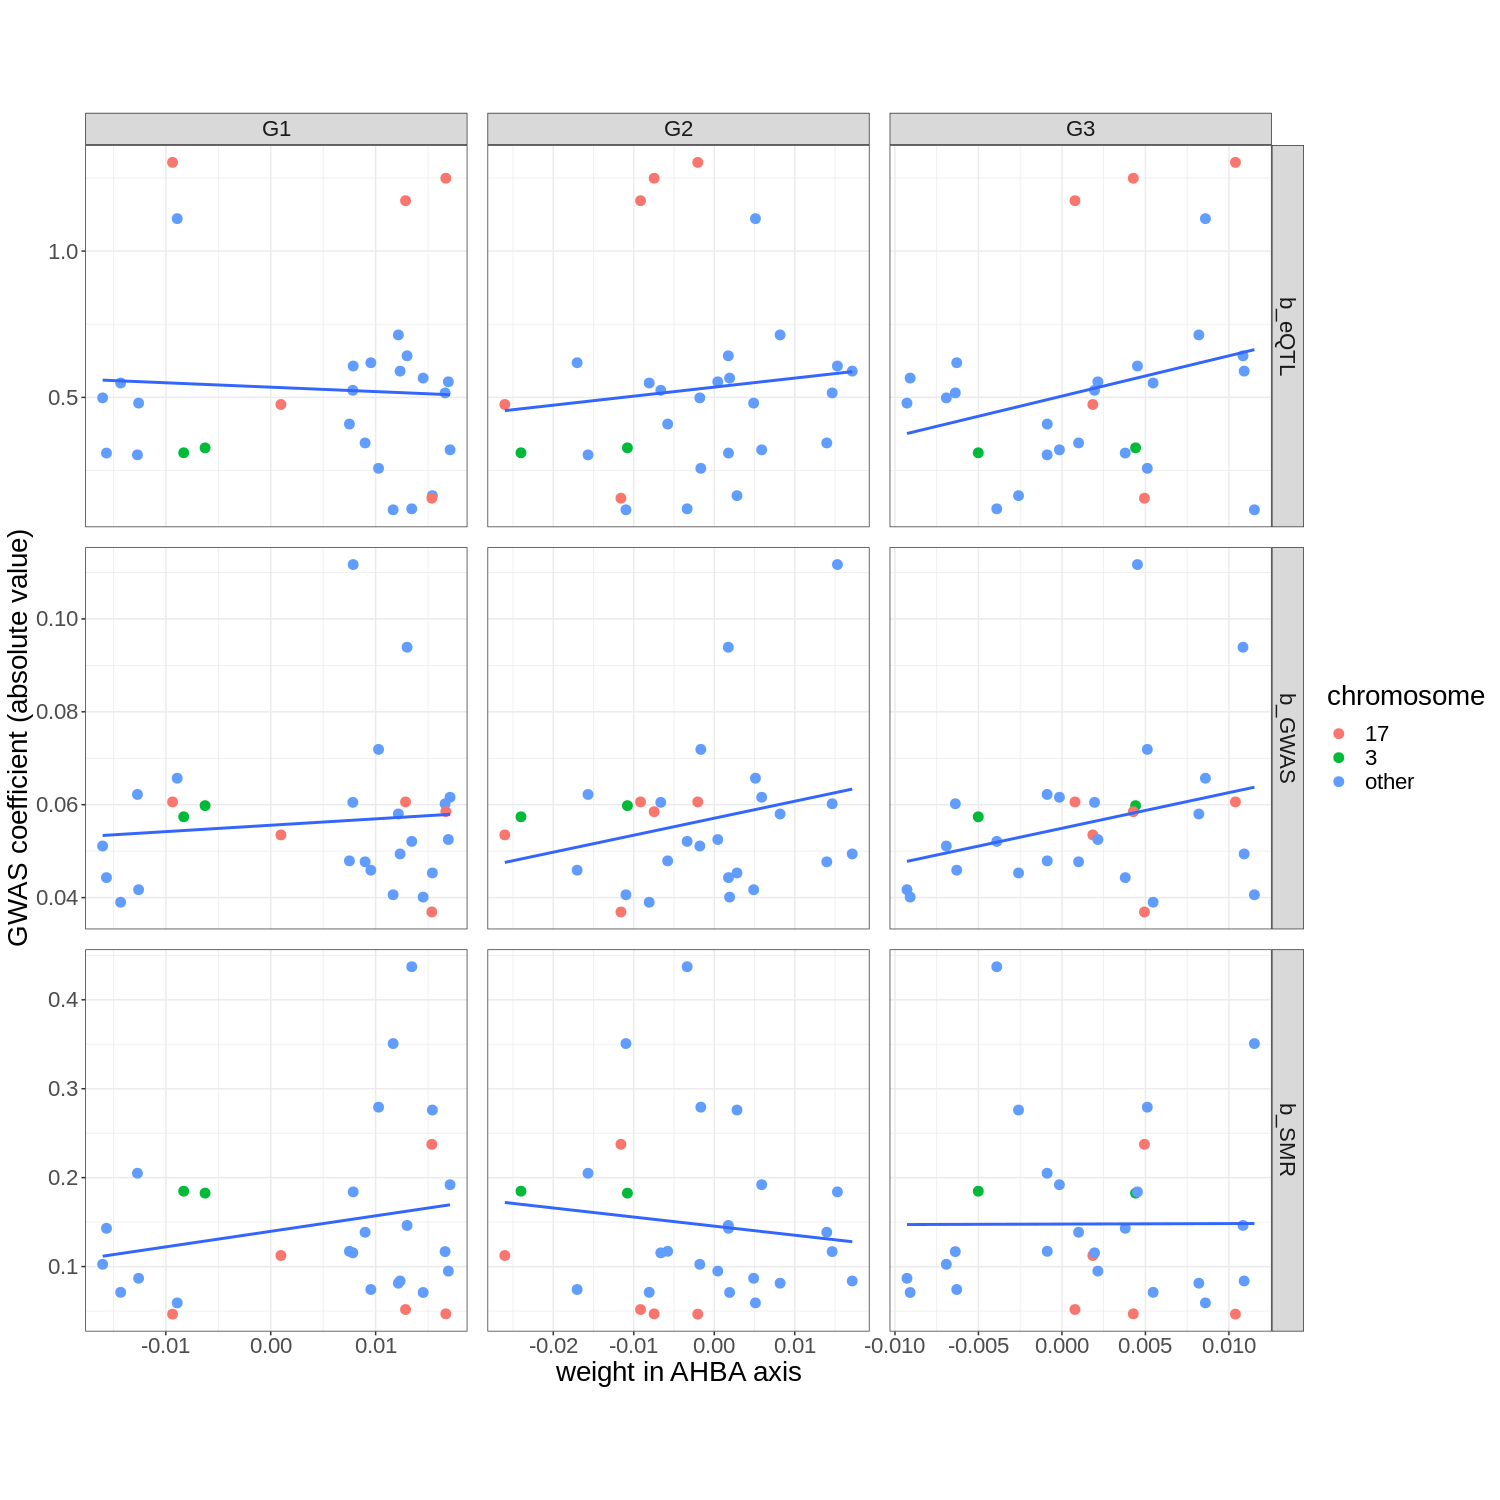

In [544]:
%%R -i df_trubetskoy -w 15 -h 15 --units in -r 100
df_trubetskoy %>%
filter(metric %in% c('b_GWAS','b_eQTL', 'b_SMR')) %>%
ggplot(aes(weight, abs(value))) + 
facet_grid(metric ~ G, scales='free') +
geom_point(aes(color=chromosome), size=3) +
geom_smooth(method='lm', se=F) +
xlab('weight in AHBA axis') +
ylab('GWAS coefficient (absolute value)') +
theme_bw() +
theme(panel.spacing=unit(1,'lines'),
      aspect.ratio=1,
      text=element_text(size=20)
)


In [547]:
trubetskoy_genes = (
    pd.read_csv("../data/gwas/trubetskoy2022_finemap.csv")
    [['chromosome', 'gene_symbol', 'finemap_posterior_probability']]
    .assign(gene = lambda x: x['gene_symbol'].str.replace('\\..*','', regex=True)).drop('gene_symbol',axis=1)
    .assign(chromosome = lambda x: np.where(np.isin(x['chromosome'], ['3','17']), x['chromosome'], 'other'))
    .groupby(['chromosome','gene']).mean()
    .reset_index(0)
)
df_trubetskoy = (
    trubetskoy_genes.join(dme_3d_ds5.weights.iloc[:,:3].set_axis(['G1','G2','G3'],axis=1))
    .dropna()
    .melt(ignore_index=False,id_vars=['chromosome','finemap_posterior_probability'], var_name='G', value_name='weight')
)
df_trubetskoy

,chromosome,finemap_posterior_probability,G,weight
ACTR1B,other,0.155000,G1,0.014231
AIG1,other,0.127167,G1,-0.008276
AKT3,other,0.023750,G1,0.013442
ANKRD45,other,0.005818,G1,-0.002938
AP3B2,other,0.032611,G1,-0.013286
...,...,...,...,...
ZFYVE21,other,0.001818,G3,-0.001843
ZNF365,other,0.054588,G3,-0.010512
ZNF592,other,0.010913,G3,0.017152
ZNF664,other,0.017806,G3,0.018577


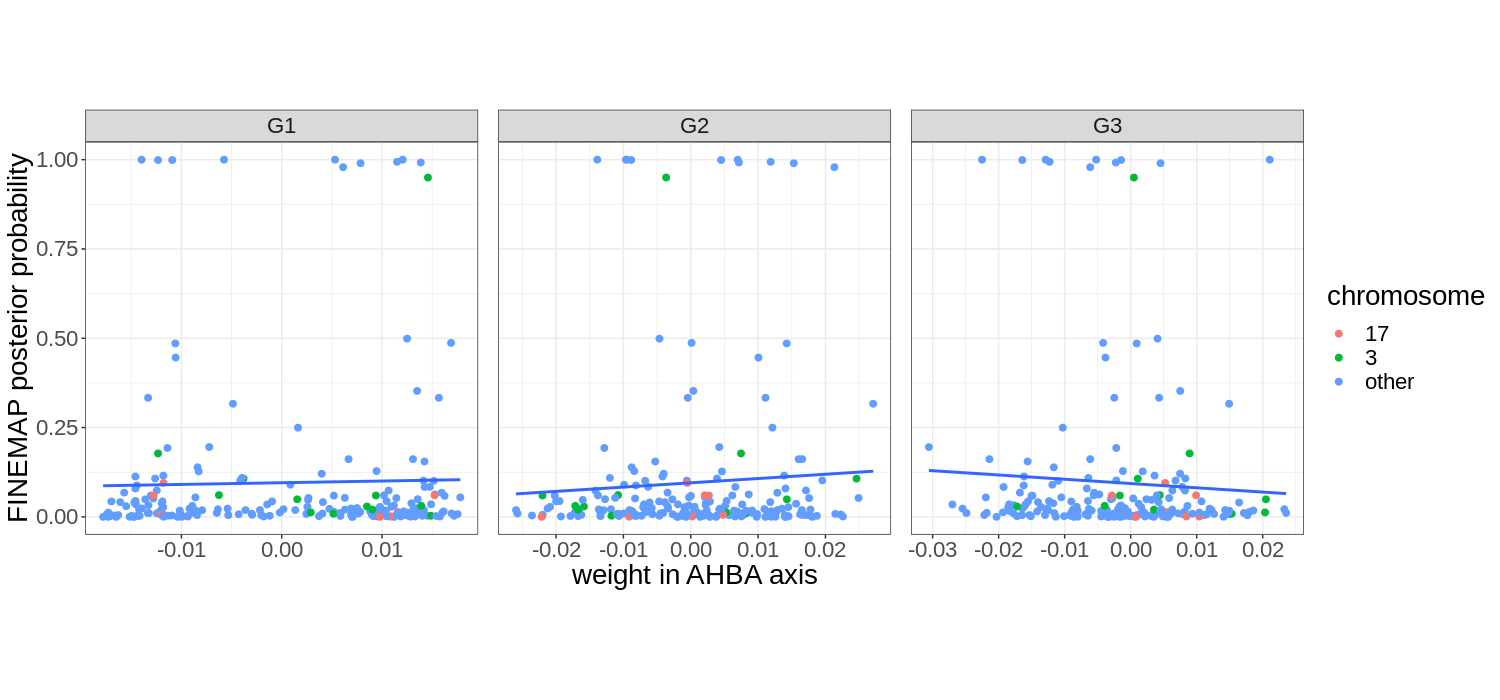

In [551]:
%%R -i df_trubetskoy -w 15 -h 7 --units in -r 100
df_trubetskoy %>%
ggplot(aes(weight, finemap_posterior_probability)) + 
facet_grid(. ~ G, scales='free') +
geom_point(aes(color=chromosome), size=2) +
geom_smooth(method='lm', se=F) +
xlab('weight in AHBA axis') +
ylab('FINEMAP posterior probability') +
theme_bw() +
theme(panel.spacing=unit(1,'lines'),
      aspect.ratio=1,
      text=element_text(size=20)
)


## Overlaps

In [404]:
a = gwas_genes_dict['grove2019_wray2018_pardinas2018'].query("label=='SCZ'").set_index('gene').drop('label', axis=1).assign(pardinas=1)
b = gwas_genes_dict['matoba2020_als2022_ripke2020'].query("label=='SCZ'").set_index('gene').drop('label', axis=1).assign(ripke=1)
c = gwas_genes_dict['hammerschlag2020_yang2021_trubetskoy2022'].query("label=='SCZ'").drop_duplicates().set_index('gene').drop('label', axis=1).assign(trubetskoy=1)

In [422]:
x = pd.concat([a,c], axis=1).fillna(0)
pd.crosstab(x.pardinas, x.trubetskoy)

trubetskoy,0.0,1.0
pardinas,,
0.0,0,87
1.0,10,12


In [411]:
pd.concat([a,b,c], axis=1).assign(count=1).fillna(0).groupby(['trubetskoy','pardinas','ripke']).sum()

count
trubetskoy pardinas ripke       
0.0        0.0      1.0       75
           1.0      0.0        9
                    1.0        1
1.0        0.0      0.0       43
                    1.0       44
           1.0      0.0        2
                    1.0       10

In [272]:
rare_genes = pd.read_csv("../data/rare_genes_konrad.csv").melt(var_name='label', value_name='gene').dropna()

In [362]:
compute_null_p(*compute_enrichments(weights, nulls, rare_genes, posneg='abs'))

,label,G,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
0,ASD,G1,0.46,1.03e-02,1.03e-02,5.98e-04,-0.07,False,0.93,0.99,False,102,52
1,ASD,G2,0.49,9.07e-03,9.11e-03,9.02e-04,-0.04,False,0.99,0.99,False,102,52
2,ASD,G3,0.93,1.03e-02,8.98e-03,9.17e-04,1.49,True,0.14,0.43,False,102,52
3,SCZ,G1,0.47,1.02e-02,1.03e-02,1.22e-03,-0.06,False,0.94,0.99,False,32,13
4,SCZ,G2,0.99,1.36e-02,9.06e-03,1.83e-03,2.50,True,0.01,0.08,False,32,13
5,SCZ,G3,0.56,9.23e-03,9.01e-03,1.86e-03,0.12,True,0.87,0.99,False,32,13


In [284]:
rare_genes

,label,gene
0,ASD,CHD8
1,ASD,SCN2A
2,ASD,SYNGAP1
3,ASD,ADNP
4,ASD,FOXP1
...,...,...
129,SCZ,OR4P4
130,SCZ,SLC22A11
131,SCZ,ANKRD12
132,SCZ,SV2A


In [359]:
from scipy.stats import fisher_exact
asd_genes = rare_genes.set_index('label').loc['ASD',:].values.squeeze()

def fisher_test_asd(i=0):
    df_asd = (weights[i].rank(ascending=True)<1000).to_frame('top1k').assign(ASD=lambda x: np.isin(x.index, asd_genes))
    table = pd.crosstab(df_asd['top1k'], df_asd['ASD'])
    print(f"Fisher test for ASD risk genes in G{i+1} top 1k")
    print(f"p-value: {round(fisher_exact(table)[1],3)}")
    return table

fisher_test_asd(0)

Fisher test for ASD risk genes in G1 top 1k
p-value: 0.675


ASD,False,True
top1k,,
False,6927,47
True,994,5


In [361]:
fisher_test_asd(1)

Fisher test for ASD risk genes in G2 top 1k
p-value: 0.001


ASD,False,True
top1k,,
False,6937,37
True,984,15


In [360]:
fisher_test_asd(2)

Fisher test for ASD risk genes in G3 top 1k
p-value: 0.001


ASD,False,True
top1k,,
False,6937,37
True,984,15


In [369]:
g2_matches = ((weights[1].rank(ascending=True)<1000).to_frame('top1k').assign(ASD=lambda x: np.isin(x.index, asd_genes))
 .loc[lambda x: x['top1k'] & x['ASD']])
g3_matches = ((weights[2].rank(ascending=True)<1000).to_frame('top1k').assign(ASD=lambda x: np.isin(x.index, asd_genes))
 .loc[lambda x: x['top1k'] & x['ASD']])

np.isin(g2_matches.index, g3_matches.index)

array([ True, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False,  True])

In [326]:
konrad_m12 = ['EXOC6','CAMKV','DRAXIN','HMP19','BZRAP1','RRAGD','MACROD2','LPPR5','AKAP5','SOWAHA']
konrad_m15 = ['ATF1','BRD3','NEK10','AGO4','ZC3H7A','C5orf42','SMEK2','CELF1','SLC25A27','STAG3L2']

In [352]:
print("Percentiles of top 10 Konrad M12 genes:")
pd.set_option("display.precision", 2)
(weights.rank(ascending=False, pct=True)
    .loc[np.isin(weights.index, konrad_m12), :].set_axis(['G1','G2','G3'],axis=1)
    .sort_values('G1', ascending=False))

Percentiles of top 10 Konrad M12 genes:


,G1,G2,G3
EXOC6,0.96,0.60,0.92
CAMKV,0.92,0.85,0.92
SOWAHA,0.92,0.92,0.81
RRAGD,0.86,0.80,0.80
AKAP5,0.84,0.85,0.88
DRAXIN,0.70,0.93,0.56
MACROD2,0.66,0.95,0.94


In [351]:
print("Percentiles of top 10 Konrad M15 gene:")
pd.set_option("display.precision", 2)
(weights.rank(ascending=False, pct=True)
    .loc[np.isin(weights.index, konrad_m12), :].set_axis(['G1','G2','G3'],axis=1)
    .sort_values('G2', ascending=False))

Percentiles of top 10 Konrad M15 gene:


,G1,G2,G3
MACROD2,0.66,0.95,0.94
DRAXIN,0.70,0.93,0.56
SOWAHA,0.92,0.92,0.81
AKAP5,0.84,0.85,0.88
CAMKV,0.92,0.85,0.92
RRAGD,0.86,0.80,0.80
EXOC6,0.96,0.60,0.92


## Goyal 116 AG genes

In [486]:
goyal_genes = pd.read_csv('../data/goyal_genes.csv').assign(label='AG')
compute_null_p(*compute_enrichments(weights, nulls, goyal_genes, posneg='abs'))

,label,G,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
0,AG,G1,0.1660,0.009865,0.010304,0.000451,-0.974861,False,0.3320,0.3924,False,116,95
1,AG,G2,0.1962,0.008508,0.009097,0.000676,-0.872005,False,0.3924,0.3924,False,116,95
2,AG,G3,1.0000,0.014734,0.008999,0.000677,8.465860,True,0.0000,0.0000,True,116,95


In [487]:
compute_null_p(*compute_enrichments(weights, nulls, goyal_genes, posneg=''))

,label,G,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
0,AG,G1,0.1540,-0.001791,-0.000619,0.001157,-1.012303,False,0.3080,0.3080,False,116,95
1,AG,G2,0.9728,0.003151,0.000928,0.001131,1.965231,True,0.0544,0.0816,False,116,95
2,AG,G3,0.0000,-0.014253,-0.000227,0.001142,-12.283355,False,0.0000,0.0000,True,116,95
